In [1]:
# all import statements needed for the project, for example:
import math
import pandas as pd
import requests 
import sqlalchemy as db
from pandas import read_parquet
from pyarrow.parquet import ParquetDataset
from bs4 import BeautifulSoup
import re
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
from datetime import datetime
import datetime
import glob
import os
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, scoped_session
import matplotlib.pyplot as plt
import sqlite3
from datetime import datetime
from scipy import stats
import numpy as np
from keplergl import KeplerGl
from pandas import DataFrame

In [2]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
redius = 6378.137
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"
TAXI_DIR = 'taxi_files'
QUERY_DIRECTORY = "queries"
WEATHER_DIR = "weather_files"

zones_df =gpd.read_file(r"taxi_zones.shp")
zones_df.to_csv("taxi_zones.csv")
zones_df = zones_df.to_crs(4326)
zones_df["lat"] = zones_df.centroid.x
zones_df["lon"] = zones_df.centroid.y
zones_data = []

zones_pickupID = zones_df.drop(
                ["OBJECTID","Shape_Leng",
                "Shape_Area","zone",
                "borough","geometry"],
                axis="columns").rename(
                columns={
                "LocationID":"PULocationID",
                "lon":"pickup_latitude",
                "lat":"pickup_longitude"
                })
zones_dropoffID = zones_df.drop(
                ["OBJECTID","Shape_Leng",
                "Shape_Area","zone",
                "borough","geometry"],
                axis="columns").rename(
                columns={
                "LocationID":"DOLocationID",
                "lon":"dropoff_latitude",
                "lat":"dropoff_longitude"
                })

/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/2061446444.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_df["lat"] = zones_df.centroid.x
/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/2061446444.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_df["lon"] = zones_df.centroid.y


Taxi data

In [3]:

# Calculate the distance through coordinates
def calculate_distance(from_coord, to_coord):
    lat1, lon1 = from_coord
    lat2, lon2 = to_coord

    diff_lat = math.radians(lat2 - lat1)
    diff_lon = math.radians(lon2 - lon1)
    
    cal_dis = (math.sin(diff_lat / 2) * math.sin(diff_lat / 2) +
             math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
             math.sin(diff_lon / 2) * math.sin(diff_lon / 2))
    cal_dis = 2 * math.atan2(math.sqrt(cal_dis), math.sqrt(1 - cal_dis))
    distance = redius * cal_dis

    return distance
    

# Add the coordinate columns to the dataframe
def add_distance_column(dataframe):
    dataframe["trip_distance"] = dataframe.apply(
                                lambda row: calculate_distance((row.pickup_longitude, row.pickup_latitude), 
                                                               (row.dropoff_longitude, row.dropoff_latitude)), 
                                                                axis=1)
    return dataframe

In [4]:
### Part 1: Data Preprocessing

In [5]:
# Get the download links of yellow taxi from 2009-01 to 2015-06
def find_taxi_csv_urls():
    response = requests.get(TAXI_URL)
    soup = BeautifulSoup(response.text, "html.parser")
    url_tags = soup.find_all("a", title="Yellow Taxi Trip Records")
    all_csv_urls = []
    pattern = "2009|2010|2011|2012|2013|2014|2015-0[1-6]"

    for url_tag in url_tags:
        if re.findall(pattern, url_tag["href"]):
            all_csv_urls.append(url_tag["href"])

    return all_csv_urls

In [6]:
def load_data_from_filename(filename):
    data = pd.read_parquet(filename)
    return data

In [7]:
# clean monthly yellow taxi data
def get_and_clean_month_taxi_data(url:str):
    file_name = url.split('/')[-1]
    if not os.path.exists(f'{TAXI_DIR}/{file_name}'):
        with open(f'{TAXI_DIR}/{file_name}', 'wb') as f:
            res = requests.get(url)
            f.write(res.content)

    dataframe = load_data_from_filename(f'{TAXI_DIR}/{file_name}')
    # Delete the useless columns
    # Attention: year 2009 and 2010 have unexpected columns' names.
    if "2010-" in file_name:
        dataframe = dataframe[
                            (dataframe["passenger_count"]> 0)
                            & (dataframe["total_amount"] > 0)
                                ]
        dataframe.drop([
                        "vendor_id", "dropoff_datetime", "rate_code", "store_and_fwd_flag",
                        "payment_type", "fare_amount", "surcharge",
                        "mta_tax","tolls_amount","passenger_count", 
                        "total_amount"
                        ], axis=1, inplace=True)
        
    elif "2009-" in file_name:
        dataframe = dataframe[
                            (dataframe["Passenger_Count"]> 0)
                            & (dataframe["Total_Amt"] > 0)
                                ]
        
        dataframe.drop([
                        "vendor_name", "Trip_Dropoff_DateTime", "Rate_Code",
                        "store_and_forward", "Payment_Type", "Fare_Amt", 
                        "surcharge", "mta_tax","Tolls_Amt",
                        "Passenger_Count",  'Total_Amt'
                        ], axis=1, inplace=True)
        
    else:
        dataframe = dataframe[
                            (dataframe["passenger_count"]> 0)
                            & (dataframe["total_amount"] > 0)
                                ]
        
        
        dataframe.drop([
                        "RatecodeID", "tolls_amount", "payment_type", 
                        "store_and_fwd_flag","mta_tax", "improvement_surcharge", 
                        "fare_amount", "extra","congestion_surcharge",
                        "airport_fee","VendorID", "tpep_dropoff_datetime", 
                        "passenger_count", "total_amount"
                        ], axis=1, inplace=True)
    
    # Unify the columns' names of year 2009 and 2012
    if "2010-" in file_name or "2009-" in file_name:
         dataframe.columns = [
                            "pickup_datetime", "trip_distance", "pickup_longitude", 
                             "pickup_latitude", "dropoff_longitude", "dropoff_latitude", 
                             "tip_amount"
                            ]
            
    else:
        # Change the IDs to the pick-up and drop-off coordinates, adding columns
        df = pd.merge(dataframe, zones_pickupID, on = "PULocationID")
        dataframe = pd.merge(df, zones_dropoffID, on = "DOLocationID")
        dataframe.drop(["PULocationID", "DOLocationID"], axis=1, inplace=True)
        dataframe.columns = [
            'pickup_datetime', 'trip_distance', 'tip_amount',
            'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'
                            ]
    

    # Remove the invalide datas
    dataframe = dataframe[
        (dataframe["pickup_longitude"] >= -74.242330)
         & (dataframe["pickup_latitude"] <= 40.908524)
         & (dataframe["pickup_longitude"] <= -73.717047)
         & (dataframe["pickup_latitude"] >= 40.560445)
         & (dataframe["dropoff_longitude"] >= -74.24233)
         & (dataframe["dropoff_latitude"] <= 40.908524)
         & (dataframe["dropoff_longitude"] <= -73.717047)
         & (dataframe["dropoff_latitude"] >= 40.560445)
        ]
    
    # Randomly choose a sample from every month.
    # Accumulated sample size is approximately to the uber data amount
    dataframe = dataframe.sample(n=2550)
    
    return dataframe

UBER DATA

In [8]:
# clean uber data
def load_and_clean_uber_data(csv_file):
    df = pd.read_csv(csv_file)
    df = df.drop(columns = ["key", "Unnamed: 0"])
    df = df[
            (df["pickup_longitude"] >= -74.242330)
            & (df["pickup_latitude"] <= 40.908524)
            & (df["pickup_longitude"] <= -73.717047)
            & (df["pickup_latitude"] >= 40.560445)
            & (df["dropoff_longitude"] >= -74.24233)
            & (df["dropoff_latitude"] <= 40.908524)
            & (df["dropoff_longitude"] <= -73.717047)
            & (df["dropoff_latitude"] >= 40.560445)
            & (df["passenger_count"] > 0)
            & (df["fare_amount"] > 0 )
            ]

    df.drop(["passenger_count","fare_amount"], axis=1, inplace=True)
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"]).apply(lambda t: t.replace(tzinfo=None))
    
    return df    

In [9]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    uber_dataframe= uber_dataframe[uber_dataframe["trip_distance"] > 0]
    return uber_dataframe

WEATHER Data

In [10]:
#clean weather data, and deal with the datetime
def clean_month_weather_data_hourly(csv_file):
    import datetime
    df = pd.read_csv(csv_file)
    df2 = df.loc[:, ["DATE", "HourlyWindSpeed",'HourlyPrecipitation']]
    df2["DATE HOUR"] = df2["DATE"].apply(lambda x:x[:-6])
    df2.drop(columns = ["DATE"], axis=1, inplace=True)
    df2["HourlyPrecipitation"].replace("T", 0.001)
    
    df2["HourlyWindSpeed"] = df2["HourlyWindSpeed"].apply(pd.to_numeric, errors = "coerce")
    df2["HourlyPrecipitation"] = df2["HourlyPrecipitation"].apply(pd.to_numeric, errors = "coerce")
    
    df2["HourlyWindSpeed"].fillna(0, inplace=True)
    df2["HourlyPrecipitation"].fillna(0, inplace=True)
    
    df3= df2.groupby(["DATE HOUR"], as_index=False)["HourlyWindSpeed"].mean()
    
    df4= df2.groupby(["DATE HOUR"], as_index=False)["HourlyPrecipitation"].sum()
    
    df4= pd.merge(df3, df4, on="DATE HOUR", how="inner")
    
    df4["DATE HOUR"] = list(map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%dT%H").strftime("%Y-%m-%d %H"), df4["DATE HOUR"]))
    
    return df4

In [11]:
#clean weather data, and deal with the datetime
def clean_month_weather_data_daily(csv_file):
    df = pd.read_csv(csv_file)
    df2 = df.loc[:, ["DATE", "HourlyWindSpeed",'HourlyPrecipitation']]
    df2["DATE DAYLY"] = df2["DATE"].apply(lambda x:x[:-9])
    df2.drop(columns=["DATE"],axis= 1,inplace=True)
    df2["HourlyPrecipitation"].replace('T', 0.001)
    
    df2["HourlyWindSpeed"] = df2["HourlyWindSpeed"].apply(pd.to_numeric, errors = "coerce")
    df2["HourlyPrecipitation"] = df2["HourlyPrecipitation"].apply(pd.to_numeric, errors = "coerce")
    
    
    df2["HourlyWindSpeed"].fillna(0, inplace=True)
    df2["HourlyPrecipitation"].fillna(0, inplace=True)
        
    df3= df2.groupby(["DATE DAYLY"], as_index=False)["HourlyWindSpeed"].mean()
    
    df4= df2.groupby(["DATE DAYLY"], as_index=False)["HourlyPrecipitation"].sum()
    
    df4= pd.merge(df3, df4, on="DATE DAYLY", how='inner')
    df4["DatelyWindSpeed"] = df4["HourlyWindSpeed"]
    df4["DatelyPrecipitation"] = df4["HourlyPrecipitation"]
    
    
    df4.drop(columns=["HourlyPrecipitation","HourlyWindSpeed"],axis= 1,inplace=True)
    
    return df4

In [12]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []

    weather_csv_files = [
                       "2009_weather.csv","2010_weather.csv","2011_weather.csv",
                       "2012_weather.csv","2013_weather.csv","2014_weather.csv",
                       "2015_weather.csv"
                        ]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    daily_data.drop(daily_data.loc[daily_data['DATE DAYLY'] > "2015-06-31"].index, inplace=True)
    hourly_data.drop(hourly_data.loc[hourly_data['DATE HOUR'] > "2015-06-31"].index, inplace=True)
    
    hourly_data.columns = ["datetime", "wind_speed", "precipitation"]
    daily_data.columns = ["datetime", "wind_speed", "precipitation"]
    return hourly_data, daily_data

## Part 2 : Storing Data

In [13]:
engine = db.create_engine(DATABASE_URL, echo=True)

In [14]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA =  """
        CREATE TABLE IF NOT EXISTS hourly_weather_data
        (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            datetime DATETIME,
            precipitation FLOAT,
            wind_speed FLOAT
        )
        """

DAILY_WEATHER_SCHEMA = """
        CREATE TABLE IF NOT EXISTS daily_weather_data
        (
           id INTEGER PRIMARY KEY AUTOINCREMENT,
           datetime DATETIME,
           precipitation FLOAT,
           wind_speed FLOAT
        )
        """

TAXI_TRIPS_SCHEMA = """
        CREATE TABLE IF NOT EXISTS taxi_data
        (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            pickup_datetime DATETIME,
            trip_distance FLOAT,
            tip_amount FLOAT,
            pickup_longitude FLOAT,
            pickup_latitude FLOAT,
            dropoff_longitude FLOAT,
            dropoff_latitude FLOAT 
        )
        """

UBER_TRIPS_SCHEMA = """
        CREATE TABLE IF NOT EXISTS uber_data
        (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            pickup_datetime DATETIME,
            trip_distance FLOAT,
            fare_amount FLOAT,
            pickup_longitude FLOAT,
            pickup_latitude FLOAT,
            dropoff_longitude FLOAT,
            dropoff_latitude FLOAT
        )
        """

In [15]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [16]:
# create the tables with the schema files
with engine.connect() as connection:
    taxi_trips = connection.execute(TAXI_TRIPS_SCHEMA)
    uber_trips = connection.execute(TAXI_TRIPS_SCHEMA)
    daily_weather = connection.execute(DAILY_WEATHER_SCHEMA)
    hourly_weather = connection.execute(HOURLY_WEATHER_SCHEMA)

2022-12-11 18:16:38,990 INFO sqlalchemy.engine.Engine 
        CREATE TABLE IF NOT EXISTS taxi_data
        (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            pickup_datetime DATETIME,
            trip_distance FLOAT,
            tip_amount FLOAT,
            pickup_longitude FLOAT,
            pickup_latitude FLOAT,
            dropoff_longitude FLOAT,
            dropoff_latitude FLOAT 
        )
        
2022-12-11 18:16:38,991 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:16:38,992 INFO sqlalchemy.engine.Engine COMMIT
2022-12-11 18:16:38,992 INFO sqlalchemy.engine.Engine 
        CREATE TABLE IF NOT EXISTS taxi_data
        (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            pickup_datetime DATETIME,
            trip_distance FLOAT,
            tip_amount FLOAT,
            pickup_longitude FLOAT,
            pickup_latitude FLOAT,
            dropoff_longitude FLOAT,
            dropoff_latitude FLOAT 
        )
        
2022-12-11 18:16:38,992 

In [17]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    df_list = []
    for csv_url in all_csv_urls:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month_taxi_data(csv_url)
        add_distance_column(dataframe)
        dataframe = dataframe[dataframe["trip_distance"]> 0]
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        _df = dataframe
        _df.to_sql("taxi_trips", con=engine, index=False, if_exists="append")
        df_list.append(_df)
    
    
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(df_list)
    taxi_data.to_csv(f'finally_taxi_data.csv', index=False, header=taxi_data.columns, encoding="utf-8")

In [18]:
def add_uber_data_to_db():
    uber_data = get_uber_data()
    uber_data.to_csv(f'finally_uber_data.csv', index=False, header=uber_data.columns, encoding='utf-8')
    
    for i in range(40):
        uber_df = uber_data[i * 5000:(i + 1)*5000]
        uber_df.to_sql('uber_trips', con=engine, index=False, if_exists='append')

In [19]:
def add_weather_data_to_db():
    hourly_data, daily_data = load_and_clean_weather_data()

    daily_data.to_sql("daily_weather", con=engine, index=False, if_exists="append")
    daily_data.to_csv(f'finally_daily_weather_data.csv', index=False, header=daily_data.columns, encoding="utf-8")

    # Import the hourly weather data to the table in 13 batches and
    # every time has amount of around 5000
    hourly_data.to_csv(f'finally_hourly_weather_data.csv', index=False, header=hourly_data.columns, encoding="utf-8")
    for i in range(13):
        hourly_df = hourly_data[i * 5000:(i + 1)*5000]
        hourly_df.to_sql("hourly_weather", con=engine, index=False, if_exists='append')

### Add data to DataBase

In [20]:
# When we call these three functions, we could get add data to our database
# get_and_clean_taxi_data()
# add_weather_data_to_db()
# add_uber_data_to_db()

In [21]:
get_and_clean_taxi_data()

2022-12-11 18:16:46,552 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("taxi_trips")
2022-12-11 18:16:46,553 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:16:46,554 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("taxi_trips")
2022-12-11 18:16:46,554 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:16:46,555 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:16:46,556 INFO sqlalchemy.engine.Engine 
CREATE TABLE taxi_trips (
	pickup_datetime DATETIME, 
	trip_distance FLOAT, 
	tip_amount FLOAT, 
	pickup_longitude FLOAT, 
	pickup_latitude FLOAT, 
	dropoff_longitude FLOAT, 
	dropoff_latitude FLOAT
)


2022-12-11 18:16:46,556 INFO sqlalchemy.engine.Engine [no key 0.00038s] ()
2022-12-11 18:16:46,559 INFO sqlalchemy.engine.Engine COMMIT
2022-12-11 18:16:46,561 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:16:46,575 INFO sqlalchemy.engine.Engine INSERT INTO taxi_trips (pickup_datetime, trip_distance, tip_amount, pickup_longitude, pickup_l

In [22]:
add_weather_data_to_db()

/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/2384162683.py:4: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/155959696.py:3: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/2384162683.py:4: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/155959696.py:3: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/2384162683.py:4: DtypeWarning: Columns (10) have mixed types. Specify d

2022-12-11 18:27:29,760 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("daily_weather")
2022-12-11 18:27:29,761 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:27:29,761 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("daily_weather")
2022-12-11 18:27:29,761 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:27:29,762 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:27:29,763 INFO sqlalchemy.engine.Engine 
CREATE TABLE daily_weather (
	datetime TEXT, 
	wind_speed FLOAT, 
	precipitation FLOAT
)


2022-12-11 18:27:29,763 INFO sqlalchemy.engine.Engine [no key 0.00026s] ()
2022-12-11 18:27:29,764 INFO sqlalchemy.engine.Engine COMMIT
2022-12-11 18:27:29,765 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:27:29,768 INFO sqlalchemy.engine.Engine INSERT INTO daily_weather (datetime, wind_speed, precipitation) VALUES (?, ?, ?)
2022-12-11 18:27:29,768 INFO sqlalchemy.engine.Engine [generated in 0.00247s] (('2009-01-01', 11.041666666666666, 0.0),

/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/155959696.py:3: DtypeWarning: Columns (10,41,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


2022-12-11 18:27:29,832 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:27:29,832 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("hourly_weather")
2022-12-11 18:27:29,832 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:27:29,833 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:27:29,834 INFO sqlalchemy.engine.Engine 
CREATE TABLE hourly_weather (
	datetime TEXT, 
	wind_speed FLOAT, 
	precipitation FLOAT
)


2022-12-11 18:27:29,834 INFO sqlalchemy.engine.Engine [no key 0.00031s] ()
2022-12-11 18:27:29,835 INFO sqlalchemy.engine.Engine COMMIT
2022-12-11 18:27:29,836 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:27:29,847 INFO sqlalchemy.engine.Engine INSERT INTO hourly_weather (datetime, wind_speed, precipitation) VALUES (?, ?, ?)
2022-12-11 18:27:29,847 INFO sqlalchemy.engine.Engine [generated in 0.00856s] (('2009-01-01 00', 18.0, 0.0), ('2009-01-01 01', 18.0, 0.0), ('2009-01-01 02', 18.0, 0.0), ('2009-01-01 03', 8.0, 0.0), ('2009-01-01

In [23]:
add_uber_data_to_db()

2022-12-11 18:27:46,556 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("uber_trips")
2022-12-11 18:27:46,557 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:27:46,558 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("uber_trips")
2022-12-11 18:27:46,558 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:27:46,559 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:27:46,559 INFO sqlalchemy.engine.Engine 
CREATE TABLE uber_trips (
	pickup_datetime DATETIME, 
	pickup_longitude FLOAT, 
	pickup_latitude FLOAT, 
	dropoff_longitude FLOAT, 
	dropoff_latitude FLOAT, 
	trip_distance FLOAT
)


2022-12-11 18:27:46,560 INFO sqlalchemy.engine.Engine [no key 0.00029s] ()
2022-12-11 18:27:46,561 INFO sqlalchemy.engine.Engine COMMIT
2022-12-11 18:27:46,564 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:27:46,590 INFO sqlalchemy.engine.Engine INSERT INTO uber_trips (pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, t

## Part 3 : Understanding Data

In [24]:
#Question 1: 
def get_hour_popular_yellow_taxi():
    with engine.connect() as connection:
        query_sql = f"select strftime('%H',pickup_datetime) AS cur_hour,count(*) as num from taxi_trips GROUP BY cur_hour order by num desc;"
        # Write the query to the query file
        with open(f'{QUERY_DIRECTORY}/question1.sql', "w") as f:
            f.write(query_sql)
        # Execute the query
        result = connection.execute(query_sql)
        return [r[0] for r in result]
    
print(get_hour_popular_yellow_taxi())

2022-12-11 18:27:48,310 INFO sqlalchemy.engine.Engine select strftime('%H',pickup_datetime) AS cur_hour,count(*) as num from taxi_trips GROUP BY cur_hour order by num desc;
2022-12-11 18:27:48,311 INFO sqlalchemy.engine.Engine [raw sql] ()
['19', '18', '20', '21', '22', '23', '17', '14', '12', '15', '13', '09', '11', '10', '08', '16', '00', '07', '01', '02', '06', '03', '04', '05']


In [25]:
# Question 2:
def get_weekday_popular_uber():
    weekdays_dict = {
        '0': 'Sun',
        '1': 'Mon',
        '2': 'Tue',
        '3': 'Wed',
        '4': 'Thur',
        '5': 'Fri',
        '6': 'Sat'
    }
    with engine.connect() as connection:
        query_sql = f"select strftime('%w',pickup_datetime) AS cur_weekday,count(*) as num from uber_trips GROUP BY cur_weekday order by num desc;"
        # Write the query to the query file
        with open(f'{QUERY_DIRECTORY}/question2.sql', "w") as f:
            f.write(query_sql)
        # Execute the query
        result = connection.execute(query_sql)
        return [weekdays_dict[r[0]] for r in result]
    
print(get_weekday_popular_uber())

2022-12-11 18:27:48,561 INFO sqlalchemy.engine.Engine select strftime('%w',pickup_datetime) AS cur_weekday,count(*) as num from uber_trips GROUP BY cur_weekday order by num desc;
2022-12-11 18:27:48,562 INFO sqlalchemy.engine.Engine [raw sql] ()
['Fri', 'Sat', 'Thur', 'Wed', 'Tue', 'Sun', 'Mon']


In [26]:
# Question 3
def get_sum_trip_distence():
    with engine.connect() as connection:
        distence_query_sql = """
                            select sum(trip_distance)*0.95 as total_distance
                            from 
                            (select * from taxi_trips where strftime('%Y-%m', pickup_datetime) = '2013-07'
                             union all
                             select * from taxi_trips where strftime('%Y-%m', pickup_datetime) = '2013-07')

                            """
        # Write the query to the query file
        with open(f'{QUERY_DIRECTORY}/question3.sql', "w") as f:
            f.write(distence_query_sql)
         # Execute the query
        result = list(connection.execute(distence_query_sql))
        distence = 0
        for row in result:
            print(row)
    
get_sum_trip_distence()

2022-12-11 18:27:48,716 INFO sqlalchemy.engine.Engine 
                            select sum(trip_distance)*0.95 as total_distance
                            from 
                            (select * from taxi_trips where strftime('%Y-%m', pickup_datetime) = '2013-07'
                             union all
                             select * from taxi_trips where strftime('%Y-%m', pickup_datetime) = '2013-07')

                            
2022-12-11 18:27:48,717 INFO sqlalchemy.engine.Engine [raw sql] ()
(13470.870311487013,)


In [27]:
# Question4
def get_2019_trips_info():
    with engine.connect() as connection:
        q4 = """
        select strftime('%Y-%m-%d', pickup_datetime) as date, count(*) as trips_amount, sum(trip_distance) as distance
        from
        (select pickup_datetime, trip_distance from taxi_trips where strftime('%Y', pickup_datetime) = '2014'
        union all
        select pickup_datetime, trip_distance from uber_trips where strftime('%Y', pickup_datetime) = '2014')
        group by strftime('%m-%d', pickup_datetime)
        order by trips_amount desc
        limit 10
        """
        
        # create the query.sql file
        with open(f'{QUERY_DIRECTORY}/question4.sql', "w") as f:
            f.write(q4)
            
        # check the result
        result = list(connection.execute(q4))
        for row in result:
            print(row)
            
get_2019_trips_info()

2022-12-11 18:27:49,122 INFO sqlalchemy.engine.Engine 
        select strftime('%Y-%m-%d', pickup_datetime) as date, count(*) as trips_amount, sum(trip_distance) as distance
        from
        (select pickup_datetime, trip_distance from taxi_trips where strftime('%Y', pickup_datetime) = '2014'
        union all
        select pickup_datetime, trip_distance from uber_trips where strftime('%Y', pickup_datetime) = '2014')
        group by strftime('%m-%d', pickup_datetime)
        order by trips_amount desc
        limit 10
        
2022-12-11 18:27:49,123 INFO sqlalchemy.engine.Engine [raw sql] ()
('2014-04-12', 226, 607.7885209718532)
('2014-11-22', 225, 548.7555442671442)
('2014-11-08', 213, 555.6706637372366)
('2014-01-16', 210, 556.9394901800194)
('2014-03-01', 206, 466.38449872936667)
('2014-03-29', 204, 483.7979942739203)
('2014-02-07', 204, 605.117720207574)
('2014-02-06', 200, 486.2886173101508)
('2014-02-08', 199, 514.6347683212666)
('2014-09-06', 198, 578.8135634840862)


In [47]:
# Question 5
def get_windest_days():
    with engine.connect() as connection:
        q5 = """
            select strftime('%Y-%m-%d', pickup_datetime) as date, wind_speed, count(*) as trips
            from 
            (select pickup_datetime from taxi_trips where strftime('%Y', pickup_datetime) = '2014'
            union all
            select pickup_datetime from uber_trips where strftime('%Y', pickup_datetime) = '2014')
            left join daily_weather on strftime('%Y-%m-%d', pickup_datetime) = datetime
            group by strftime('%m-%d', pickup_datetime)
            order by wind_speed desc
            limit 10
            """
         # create the query file
        with open(f'{QUERY_DIRECTORY}/question5.sql', "w") as f:
                f.write(q5)
        # check the result
        result = list(connection.execute(q5))

        for row in result:
            print(row)
        
get_windest_days()

2022-12-11 18:41:40,165 INFO sqlalchemy.engine.Engine 
            select strftime('%Y-%m-%d', pickup_datetime) as date, wind_speed, count(*) as trips
            from 
            (select pickup_datetime from taxi_trips where strftime('%Y', pickup_datetime) = '2014'
            union all
            select pickup_datetime from uber_trips where strftime('%Y', pickup_datetime) = '2014')
            left join daily_weather on strftime('%Y-%m-%d', pickup_datetime) = datetime
            group by strftime('%m-%d', pickup_datetime)
            order by wind_speed desc
            limit 10
            
2022-12-11 18:41:40,167 INFO sqlalchemy.engine.Engine [raw sql] ()
('2014-03-13', 12.923076923076923, 183)
('2014-01-07', 12.56, 161)
('2014-01-02', 12.352941176470589, 124)
('2014-02-13', 11.781818181818181, 118)
('2014-03-29', 11.666666666666666, 204)
('2014-03-26', 10.52, 178)
('2014-01-03', 9.710526315789474, 86)
('2014-02-14', 9.421052631578947, 152)
('2014-03-30', 8.790697674418604, 149)

In [46]:
def get_hour_trips_wind_pre():
    with engine.connect() as connection:
        q6 = """
            select strftime('%H', pickup_datetime) as hour_time, count(*) as trips, wind_speed, precipitation 
            from
            (select pickup_datetime from taxi_trips where strftime('%Y-%m-%d', pickup_datetime) between '2012-10-22' and '2012-11-06'
            union all
            select pickup_datetime from uber_trips where strftime('%Y-%m-%d', pickup_datetime) between '2012-10-22' and '2012-11-06' )
            left join
            (select datetime, wind_speed, precipitation from hourly_weather where strftime('%Y-%m-%d', datetime) between '2012-10-22' and '2012-11-06')
            on 
            strftime('%H', pickup_datetime) = strftime('%H', datetime)
            group by strftime('%H', pickup_datetime)
        """
        # create the query file
        with open(f'{QUERY_DIRECTORY}/question6.sql', "w") as f:
                        f.write(q6)
        # check the result
        result = list(connection.execute(q6))

        for row in result:
            print(row)
            
get_hour_trips_wind_pre()

2022-12-11 18:41:22,479 INFO sqlalchemy.engine.Engine 
            select strftime('%H', pickup_datetime) as hour_time, count(*) as trips, wind_speed, precipitation 
            from
            (select pickup_datetime from taxi_trips where strftime('%Y-%m-%d', pickup_datetime) between '2012-10-22' and '2012-11-06'
            union all
            select pickup_datetime from uber_trips where strftime('%Y-%m-%d', pickup_datetime) between '2012-10-22' and '2012-11-06' )
            left join
            (select datetime, wind_speed, precipitation from hourly_weather where strftime('%Y-%m-%d', datetime) between '2012-10-22' and '2012-11-06')
            on 
            strftime('%H', pickup_datetime) = strftime('%H', datetime)
            group by strftime('%H', pickup_datetime)
        
2022-12-11 18:41:22,480 INFO sqlalchemy.engine.Engine [raw sql] ()
('00', 91, None, None)
('01', 58, None, None)
('02', 56, None, None)
('03', 34, None, None)
('04', 25, None, None)
('05', 27, None, None

## Extra Credit

In [32]:
SUNSET_SUNRISE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS sunset_sunrise (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        sunrise_time DATETIME,
        sunset_time DATETIME
    );
"""

# create a new table
with open(DATABASE_SCHEMA_FILE, "a") as f:
    f.write(SUNSET_SUNRISE_SCHEMA)

with engine.connect() as connection:
    connection.execute(SUNSET_SUNRISE_SCHEMA)

    
# clean the data
def load_and_clean_weather_sun_data(csv_file):
    df = pd.read_csv(csv_file, low_memory=False)
    df = df.loc[:, ["DATE", "Sunrise",'Sunset']]
    df = df[df['Sunrise'].notnull()]
    
    row_list = []
    for index, row in df.iterrows():
        record_date = str(row['DATE'])[0:10]
        sunrise = f"{int(row['Sunrise']):04d}"
        sunrise_time = f'{record_date} {sunrise[:2]}:{sunrise[2:]}:00'
        row['sunrise_time'] = sunrise_time
        sunset = f"{int(row['Sunset']):04d}"
        sunset_time = f'{record_date} {sunset[:2]}:{sunset[2:]}:00'
        row['sunset_time'] = sunset_time
        row_list.append(row)
    
    new_df = pd.DataFrame(row_list)
    new_df.drop(columns=["DATE", "Sunrise",'Sunset'], axis=1, inplace=True)
    return new_df


with engine.connect() as connection:
    test_sql = f"select * from sunset_sunrise;"
    result = list(connection.execute(test_sql)) 
    for row in result:
        print(row)

load_and_clean_weather_sun_data('2015_weather.csv')

2022-12-11 18:30:36,917 INFO sqlalchemy.engine.Engine 
    CREATE TABLE IF NOT EXISTS sunset_sunrise (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        sunrise_time DATETIME,
        sunset_time DATETIME
    );

2022-12-11 18:30:36,918 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:30:36,919 INFO sqlalchemy.engine.Engine COMMIT
2022-12-11 18:30:36,920 INFO sqlalchemy.engine.Engine select * from sunset_sunrise;
2022-12-11 18:30:36,920 INFO sqlalchemy.engine.Engine [raw sql] ()


,sunrise_time,sunset_time
24,2015-01-01 07:20:00,2015-01-01 16:39:00
49,2015-01-02 07:20:00,2015-01-02 16:40:00
109,2015-01-03 07:20:00,2015-01-03 16:41:00
161,2015-01-04 07:20:00,2015-01-04 16:42:00
186,2015-01-05 07:20:00,2015-01-05 16:43:00
...,...,...
11238,2015-12-27 07:19:00,2015-12-27 16:35:00
11264,2015-12-28 07:19:00,2015-12-28 16:36:00
11312,2015-12-29 07:20:00,2015-12-29 16:36:00
11351,2015-12-30 07:20:00,2015-12-30 16:37:00


In [33]:
# Question we made: which one is more popular after 2015-01-31 sunset? Uber or yellow taxi?
def get_sunset_trips_info():
     with engine.connect() as connection:
        uber_trips_sql = """
            select count(*) from uber_trips where pickup_datetime<'2015-02-01' and
            pickup_datetime>=(select sunset_time from sunset_sunrise where sunset_time like '%2015-01-31%');
        """

        uber_trips_data = list(connection.execute(uber_trips_sql))
        uber_trips = uber_trips_data[0][0]
        
        taxi_trips_sql = """
            select count(*) from taxi_trips where pickup_datetime<'2015-02-01' and
            pickup_datetime>=(select sunset_time from sunset_sunrise where sunset_time like '%2015-01-31%');
        """

        taxi_trips_data = list(connection.execute(taxi_trips_sql))
        taxi_trips = taxi_trips_data[0][0]
        

        with open(f'{QUERY_DIRECTORY}/extra_credit.sql', "w") as f:
            f.write(uber_trips_sql)
            f.write(taxi_trips_sql)
        
        if uber_trips > taxi_trips:
            return '2015-01-31 sunset, Uber is more popular'
        else:
            return '2015-01-31 sunset, Taxi is more popular'
        
get_sunset_trips_info()

2022-12-11 18:30:40,002 INFO sqlalchemy.engine.Engine 
            select count(*) from uber_trips where pickup_datetime<'2015-02-01' and
            pickup_datetime>=(select sunset_time from sunset_sunrise where sunset_time like '%2015-01-31%');
        
2022-12-11 18:30:40,004 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:30:40,074 INFO sqlalchemy.engine.Engine 
            select count(*) from taxi_trips where pickup_datetime<'2015-02-01' and
            pickup_datetime>=(select sunset_time from sunset_sunrise where sunset_time like '%2015-01-31%');
        
2022-12-11 18:30:40,075 INFO sqlalchemy.engine.Engine [raw sql] ()


'2015-01-31 sunset, Taxi is more popular'

## Part 4: Visualizing the Data

2022-12-11 18:30:43,145 INFO sqlalchemy.engine.Engine 
    select strftime('%H',pickup_datetime) AS cur_hour,count(*) as num
    from taxi_trips GROUP BY cur_hour
    
2022-12-11 18:30:43,147 INFO sqlalchemy.engine.Engine [raw sql] ()


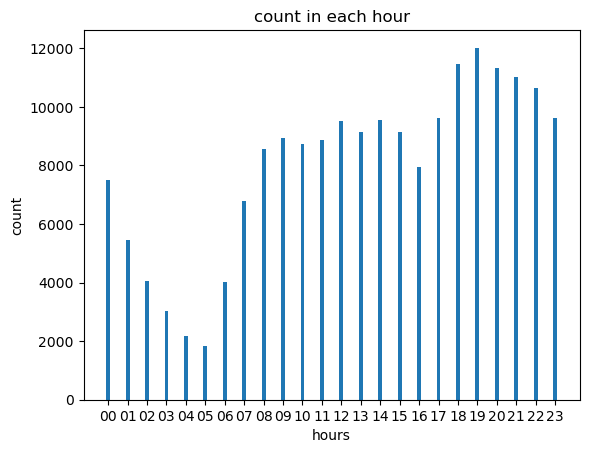

In [34]:
#p4 q1 
#Create an appropriate visualization for the first query/question in part 3
def popular_hour():
    q1 = """
    select strftime('%H',pickup_datetime) AS cur_hour,count(*) as num
    from taxi_trips GROUP BY cur_hour
    """
    with engine.connect() as connection:

        test1 = connection.execute(q1)
        df1 = DataFrame(test1.fetchall())
        df1.columns = test1.keys()
    plt.bar(df1["cur_hour"], df1["num"], width = 0.2)
    plt.xlabel("hours")
    plt.ylabel("count")
    plt.title("count in each hour")
    plt.show()
popular_hour()

2022-12-11 18:30:46,091 INFO sqlalchemy.engine.Engine select strftime('%m',pickup_datetime) AS per_month,sum(trip_distance) as trip_distance from taxi_trips GROUP BY per_month;
2022-12-11 18:30:46,093 INFO sqlalchemy.engine.Engine [raw sql] ()


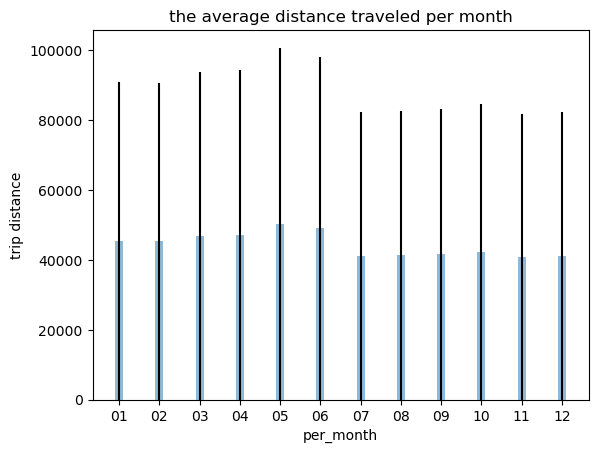

In [35]:
#p4 q2
#Create a visualization that shows the average distance traveled per month
def get_avg_distance_per_month():
    
    query_sql = """select strftime('%m',pickup_datetime) AS per_month,sum(trip_distance) as trip_distance from taxi_trips GROUP BY per_month;"""
    
    with engine.connect() as connection:
        t4 = connection.execute(query_sql)
        df_4 = DataFrame(t4.fetchall())
        df_4.columns = t4.keys()
    mean = df_4.groupby(["per_month"], as_index=False)['trip_distance'].mean()
    k_lower =  df_4.groupby(["per_month"], as_index=False)['trip_distance'].quantile(0.05)
    k_upper = df_4.groupby(["per_month"], as_index=False)['trip_distance'].quantile(0.95) 
   
    plt.bar(df_4["per_month"],df_4["trip_distance"],yerr=[k_lower['trip_distance'].to_numpy(),k_upper['trip_distance'].to_numpy()], alpha=0.5,width = 0.2)
    plt.xlabel("per_month")
    plt.ylabel("trip distance")
    plt.title("the average distance traveled per month")
    plt.show()
get_avg_distance_per_month()

2022-12-11 18:31:11,856 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("taxi_trips")
2022-12-11 18:31:11,857 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:31:11,859 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("taxi_trips")
2022-12-11 18:31:11,860 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:31:11,862 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2022-12-11 18:31:11,862 INFO sqlalchemy.engine.Engine [raw sql] ('taxi_trips',)
2022-12-11 18:31:11,863 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("taxi_trips")
2022-12-11 18:31:11,864 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:31:11,864 INFO sqlalchemy.engine.Engine PRAGMA temp.foreign_key_list("taxi_trips")
2022-12-11 18:31:11,865 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:31:11,865 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_ma

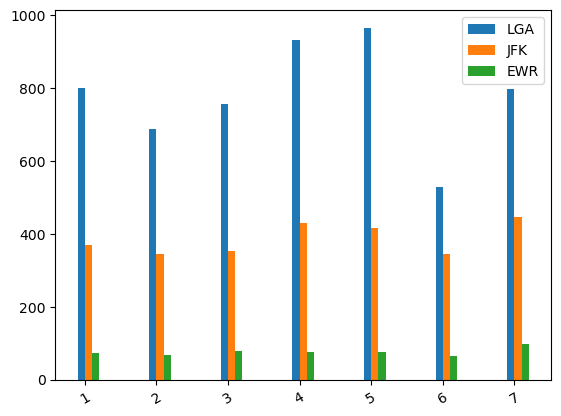

In [38]:
#p4 q3
#Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR 
#Create a visualization that compares what day of the week was most popular for drop offs for each airport.
def coor_box():
    x= pd.read_sql_table('taxi_trips', engine)
    y = pd.read_sql_table('uber_trips', engine)
    x['pickup_datetime'] = pd.to_datetime(x['pickup_datetime'])
    y['pickup_datetime'] = pd.to_datetime(y['pickup_datetime'])
    k = pd.concat([x, y])

    k["day_of_the_week"] = k['pickup_datetime'].apply(lambda x:x.weekday())
    LGA = (-73.8702, 40.7730)
    JFK = (-73.780968, 40.641766)
    EWR = (-74.184601, 40.695213)
    center_distance = 0.02

    def filter_lnglat(x, lnglat_center, center_distance):
        x1 = x[lnglat_center[0] - center_distance <= x["dropoff_longitude"]]
        x2 = x1[x1["dropoff_longitude"] <= lnglat_center[0] + center_distance]
        x3 = x2[lnglat_center[1] - center_distance <= x2["dropoff_latitude"]]
        x4 = x3[x3["dropoff_latitude"]<= lnglat_center[1] + center_distance]
        return x4

    LGA_df = filter_lnglat(k, LGA, center_distance)
    JFK_df = filter_lnglat(k, JFK, center_distance)
    EWR_df = filter_lnglat(k, EWR, center_distance)
    LGA_count_df = LGA_df.groupby(["day_of_the_week"], as_index=False).count()
    JFK_count_df = JFK_df.groupby(["day_of_the_week"], as_index=False).count()
    EWR_count_df = EWR_df.groupby(["day_of_the_week"], as_index=False).count()
    tick_label = (LGA_count_df["day_of_the_week"] + 1).to_numpy()
    def txt_xy(X, YI, i, bar_width):
        for x,y in zip(X,YI):
            plt.text(x +i*bar_width,y,'%.2f' %y, ha='center',va='bottom', rotation=30)

    x_range = np.arange(7)
    bar_width = 0.1
    plt.bar(x_range, LGA_count_df["pickup_datetime"].to_numpy(), width=bar_width, label="LGA")
    plt.bar(x_range + bar_width, JFK_count_df["pickup_datetime"].to_numpy(), width=bar_width, label="JFK")
    plt.bar(x_range + 2 * bar_width, EWR_count_df["pickup_datetime"].to_numpy(), width=bar_width, label="EWR")

    plt.xticks(x_range + bar_width/2, tick_label, rotation=30)
    plt.legend()
    plt.show()  
    
coor_box()

In [39]:
#P4 Q4
# Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL 
def heatmap():
    q4 = """
        select pickup_latitude, pickup_longitude
        from (select pickup_latitude, pickup_longitude
            from taxi_trips union all select pickup_latitude, pickup_longitude
            from uber_trips
        ) 
    """
    with engine.connect() as connection:
        t2 = connection.execute(q4)
        df_2 = DataFrame(t2.fetchall())
        df_2.columns = t2.keys()
        

    df_kepler = df_2[["pickup_longitude", "pickup_latitude"]]
    df_kepler["Latitude"] = df_kepler["pickup_latitude"]
    df_kepler["Longitude"] = df_kepler["pickup_longitude"]
    df_kepler["City"] = "NY"
    df_kepler = df_kepler.drop(columns="pickup_latitude")
    df_kepler = df_kepler.drop(columns="pickup_longitude")


    map_2 = KeplerGl(height=400, data={"data_1": df_kepler})
    return map_2

heatmap()

2022-12-11 18:31:23,305 INFO sqlalchemy.engine.Engine 
        select pickup_latitude, pickup_longitude
        from (select pickup_latitude, pickup_longitude
            from taxi_trips union all select pickup_latitude, pickup_longitude
            from uber_trips
        ) 
    
2022-12-11 18:31:23,308 INFO sqlalchemy.engine.Engine [raw sql] ()


/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/3849869870.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kepler["Latitude"] = df_kepler["pickup_latitude"]
/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/3849869870.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kepler["Longitude"] = df_kepler["pickup_longitude"]
/var/folders/4c/k607jfy56yv9kqkzvbvdnbcr0000gn/T/ipykernel_15087/3849869870.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy 

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_1':          Latitude  Longitude City
0       40.735035 -74.008984   NY
1       40.749914…

2022-12-11 18:31:40,284 INFO sqlalchemy.engine.Engine 
        select trip_distance, tip_amount from taxi_trips
    
2022-12-11 18:31:40,286 INFO sqlalchemy.engine.Engine [raw sql] ()


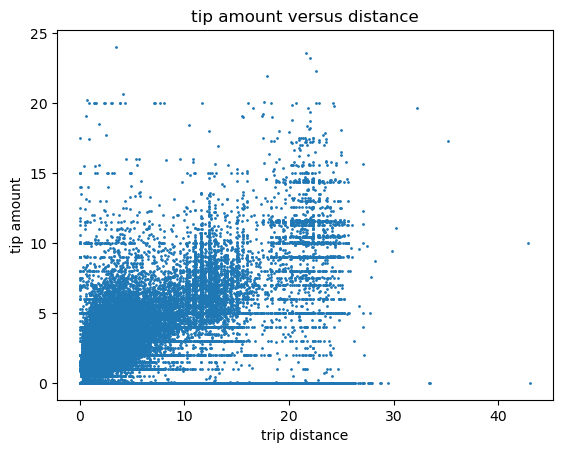

In [40]:
#p4 q5
#Create a scatter plot that compares tip amount versus distance.
def tip_versus_distance():
    q5 = """
        select trip_distance, tip_amount from taxi_trips
    """

    with engine.connect() as connection:
        t5 = connection.execute(q5)
        df_5 = DataFrame(t5.fetchall())
        df_5.columns = t5.keys()
        
    x_filtered = df_5[df_5["tip_amount"] < df_5["tip_amount"].quantile(0.9999)]
    x_filtered2 = x_filtered[x_filtered["trip_distance"] < x_filtered["trip_distance"].quantile(0.99999)]
    plt.scatter(x_filtered2["trip_distance"], x_filtered2["tip_amount"],s = 1)
    plt.xlabel("trip distance")
    plt.ylabel("tip amount")
    plt.title("tip amount versus distance")
    plt.show()
    
tip_versus_distance()

2022-12-11 18:31:59,556 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("hourly_weather")
2022-12-11 18:31:59,557 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:31:59,559 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("hourly_weather")
2022-12-11 18:31:59,559 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:31:59,560 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2022-12-11 18:31:59,561 INFO sqlalchemy.engine.Engine [raw sql] ('hourly_weather',)
2022-12-11 18:31:59,562 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("hourly_weather")
2022-12-11 18:31:59,562 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:31:59,562 INFO sqlalchemy.engine.Engine PRAGMA temp.foreign_key_list("hourly_weather")
2022-12-11 18:31:59,563 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:31:59,563 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SEL

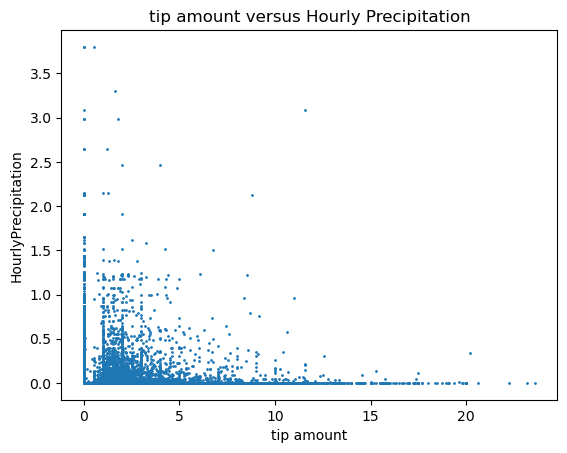

In [41]:
#p4 q6
#Create another scatter plot that compares tip amount versus precipitation amount.
def tip_versus_Precipitation():
    hourly_ps= pd.read_sql_table('hourly_weather', engine)
    x= pd.read_sql_table('taxi_trips', engine)
    x["pickup_hour"] = x["pickup_datetime"].astype("str").apply(lambda x: x[:13])
    hourly_ps["datetime"] = hourly_ps["datetime"].astype("str").apply(lambda x:x[:13])
    x_joined = x.set_index('pickup_hour').join(hourly_ps.set_index('datetime'))
    x_joined_filtered = x_joined[x_joined["tip_amount"] < x_joined["tip_amount"].quantile(0.9999)]
    plt.scatter(x_joined_filtered["tip_amount"], x_joined_filtered["precipitation"],s = 1)
    plt.xlabel("tip amount")
    plt.ylabel("HourlyPrecipitation")
    plt.title("tip amount versus Hourly Precipitation")
    plt.show()
    
tip_versus_Precipitation()